In [96]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [97]:
df = pd.read_csv('train_preprocessed.csv')
df = df.set_index('id')
df = df.dropna(axis = 0)
df.head()

,collection,budget,homepage,original_language_en,popularity,runtime,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,...,Quarter_three,Quarter_four,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,revenue
id,,,,,,,,,,,,,,,,,,,,,
1,1,14000000,0,1,6.575393,93.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,12314651
2,1,40000000,0,1,8.248895,113.0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,95149435
3,0,3300000,1,1,64.299990,105.0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,13092000
4,0,1200000,1,0,3.174936,122.0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,16000000
6,0,8000000,0,1,0.743274,83.0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,3261638


In [98]:
# df.profile_report()

In [99]:
x_col_list = df.columns[:-1]
x = df[x_col_list]
y = df['revenue']

In [100]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean of RMSE:", scores.mean())
    print("Standard deviation:", scores.std())

# 1. Decision Tree

In [101]:
from sklearn.tree import DecisionTreeRegressor

In [102]:
# Before fitting regression model, find optimal parameters of model.

from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1,2,3, 5, 10, 15, 20, 30]}
dt_reg = DecisionTreeRegressor()
grid_search = GridSearchCV(dt_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 15, 20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [103]:
print(grid_search.best_params_)

{'max_depth': 3}


In [104]:
best_estim=grid_search.best_estimator_
print(best_estim)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


In [105]:
# 따라서 최적의 모델은
tree_reg = best_estim

In [106]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)
tree_reg.fit(xtrain, ytrain)

# K-fold - decision tree
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True)

kf_cv_scores = cross_val_score(tree_reg, xtrain, ytrain, cv=kfold ) #r^2점수
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


# prediction
ypred = tree_reg.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

K-fold CV average score: 0.47
MSE: 6872889779118645.00
RMSE: 82902893.67


In [111]:
plt.close()

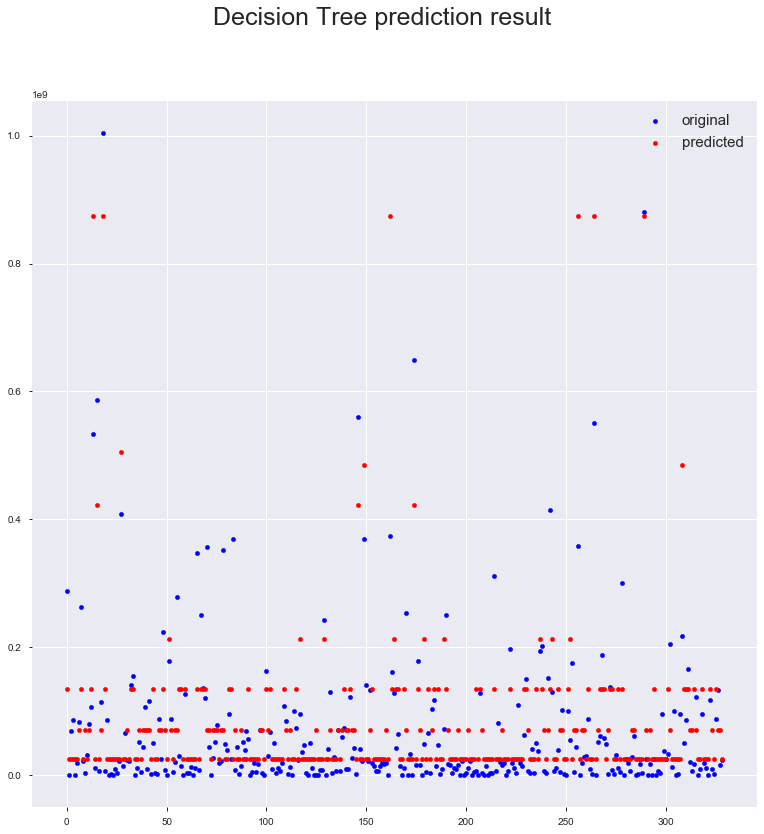

In [112]:
x_ax = range(len(ytest))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, ytest, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.suptitle('Decision Tree prediction result', fontsize=25)
plt.savefig('Decision Tree prediction result', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

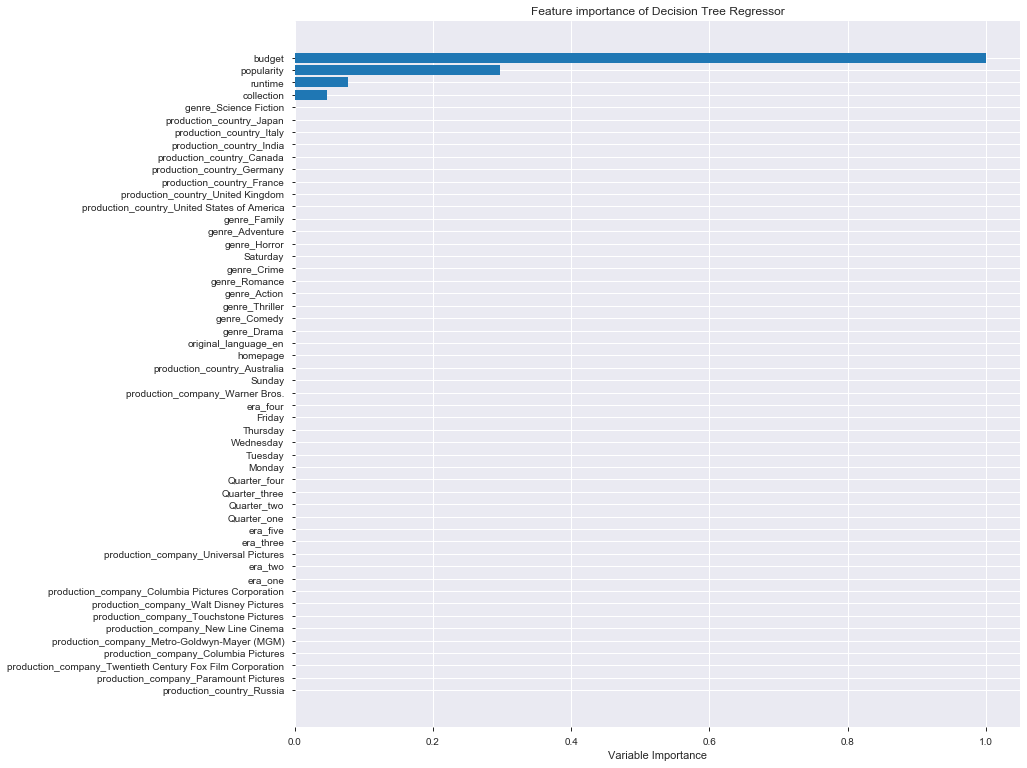

In [113]:
#피처 중요도 도표 그리기
featureImportance = tree_reg.feature_importances_
 
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, x.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.rcParams["figure.figsize"] = (13,27)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.title('Feature importance of Decision Tree Regressor')
plt.savefig('Feature importance of Decision Tree Regressor', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

In [47]:
# 단점 : 1. 성능이 좋지 못하다.  2. 새 데이터에 대해 예측할 때 주어진 데이터셋의 y값들의 최솟값과 최댓값 사이에서만 그 결과값이 나온다.

----

# 2. Random forest

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pylab as plot

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

mseOos = []
nTreeList = range(50, 500, 10)
for iTrees in nTreeList:
    depth = None
    rf_reg = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth,
                    oob_score=False, random_state=0)
    rf_reg.fit(x_train, y_train)
    #데이터 세트에 대한 MSE 누적
    prediction = rf_reg.predict(x_test)
    mseOos.append(mean_squared_error(y_test, prediction))

In [116]:
rmseOos = np.sqrt(mseOos)
rmseOos

array([73429060.39272194, 73425275.2033056 , 74121212.65932004,
       74298763.18181558, 74642766.70531273, 74517263.4714048 ,
       74328995.57104185, 74047408.27052437, 74247336.18245693,
       74132627.42738466, 74084448.10876353, 74055868.64854465,
       73837623.08119412, 73963191.55555657, 73985537.36990067,
       73901733.22643018, 73735709.70251791, 73853514.79787214,
       73731843.94535416, 73634202.81526496, 73513795.70693137,
       73566187.87846841, 73540414.06561024, 73444208.65643464,
       73461671.77809906, 73495550.1707438 , 73419914.61417645,
       73407368.05757609, 73464556.12231795, 73537041.3768342 ,
       73446660.43928327, 73229824.78534365, 73259801.12229417,
       73307257.65934667, 73303352.52725512, 73255538.03952502,
       73365945.70171753, 73340899.36811218, 73397056.58069901,
       73388574.3005649 , 73417505.79775167, 73395078.3146403 ,
       73381555.92140275, 73364399.74053593, 73243147.78731507])

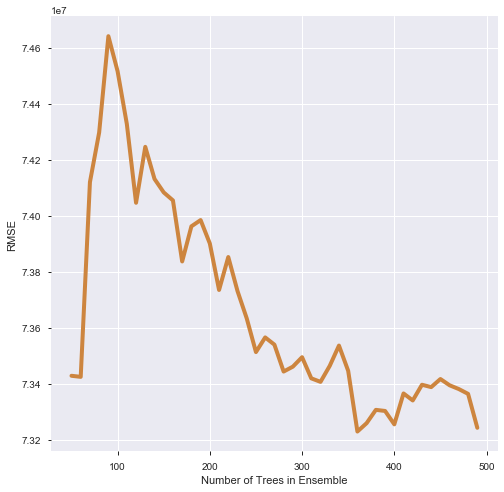

In [117]:
#트레이닝 테스트 오차 대비  앙상블의 트리 개수 도표 그리기
plt.rcParams["figure.figsize"] = (8,8)
plot.plot(nTreeList, rmseOos, color = 'peru')
plt.rcParams['lines.linewidth'] = 4
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('RMSE')
#plot.ylim([0.0, 1.1*max(mseOob)])
plt.savefig('Number of Trees in Ensemble', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

In [118]:
Tree_number = list(nTreeList)
dd = {'NumberOfTree' : Tree_number, 'RMSE' : rmseOos}
N_of_Tree = pd.DataFrame(dd)

In [119]:
N_of_Tree.set_index('NumberOfTree',inplace = True)

In [120]:
N_of_Tree.sort_values(by = 'RMSE')

,RMSE
NumberOfTree,
360,7.322982e+07
490,7.324315e+07
400,7.325554e+07
370,7.325980e+07
390,7.330335e+07
380,7.330726e+07
420,7.334090e+07
480,7.336440e+07
410,7.336595e+07


In [121]:
# 트리개수 360일때 RMSE가 가장 낮음.

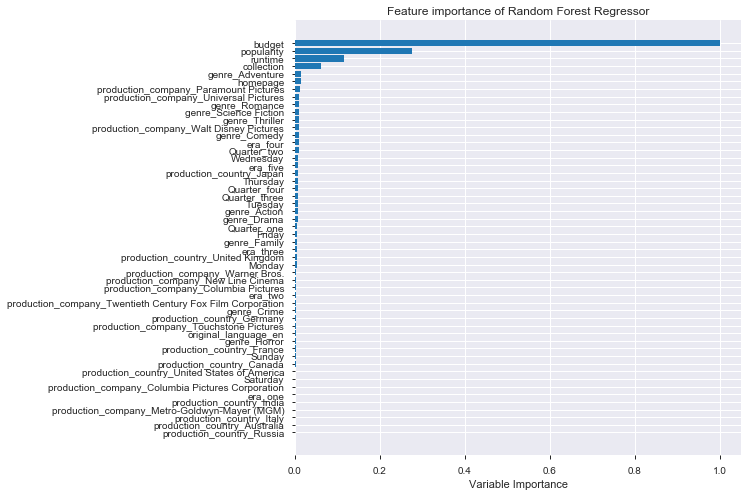

In [122]:
 #피처 중요도 도표 그리기
featureImportance = rf_reg.feature_importances_
 
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, x.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.rcParams["figure.figsize"] = (10,27)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.title('Feature importance of Random Forest Regressor')
plt.savefig('Feature importance of Random Forest Regressor', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

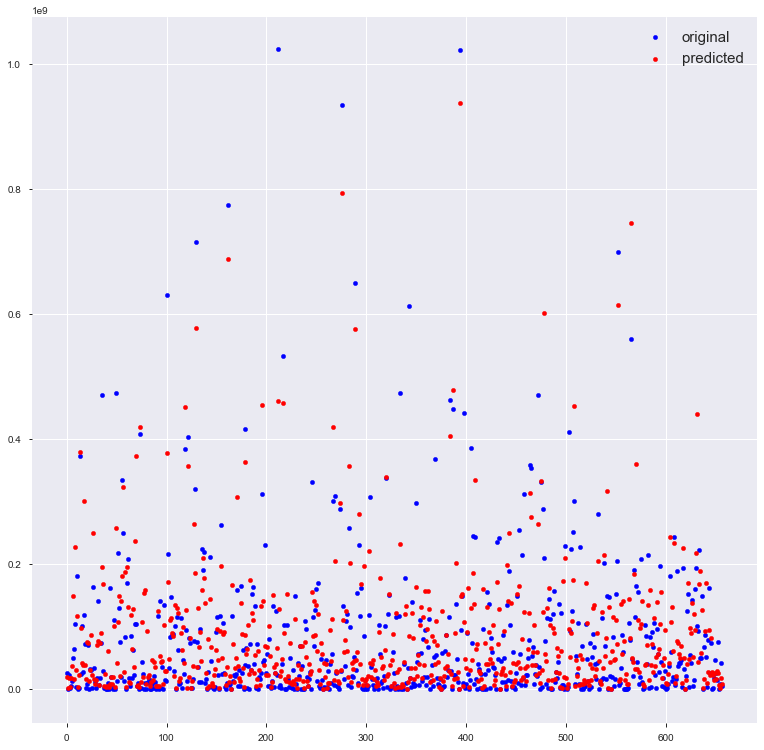

In [123]:
x_ax = range(len(y_test))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, y_test, s = 20, color="blue", label="original")
plt.scatter(x_ax, prediction, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.savefig('Prediction in Random Forest Regressor', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

In [124]:
# 따라서 최적의 모델은
RandomForest_reg = RandomForestRegressor(n_estimators = 360)
RandomForest_reg.fit(x, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=360,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [125]:
# CV fold - Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForest_reg, x, y,
                         scoring="neg_mean_squared_error", cv=10)

rf_rmse_scores = np.sqrt(-scores)

In [126]:
display_scores(rf_rmse_scores)

Scores: [8.19916120e+07 7.69498050e+07 1.11295560e+08 8.23973753e+07
 9.28089353e+07 1.04929227e+08 7.37553313e+07 9.17854404e+07
 9.23183626e+07 7.93240096e+07]
Mean of RMSE: 88755565.75254153
Standard deviation: 11608001.644793348


In [61]:
# Decision Tree 보다 성능이 훨씬 뛰어남!

----

----

# 3. Adaboost

In [87]:
from sklearn.ensemble import AdaBoostRegressor

In [88]:
ada_reg = AdaBoostRegressor(random_state = 0)
params = {
 'n_estimators': [50, 100, 200, 300],
 'learning_rate' : [0.01, 0.05, 0.1, 0.5],
 'loss' : ['linear', 'square', 'exponential']
 }
grid_search=GridSearchCV(ada_reg, params, cv=10, return_train_score=True)
grid_search.fit(x, y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [89]:
print(grid_search.best_params_)

{'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 200}


In [90]:
best_estim=grid_search.best_estimator_
print(best_estim)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='exponential',
                  n_estimators=200, random_state=0)


In [91]:
# 따라서 최적의 모형은
ada_reg = best_estim

In [92]:
ada_reg.fit(xtrain, ytrain)

# K-fold - decision tree
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True)

kf_cv_scores = cross_val_score(ada_reg, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())



# prediction
ypred = ada_reg.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

K-fold CV average score: 0.59
MSE: 9985020722668982.00
RMSE: 99925075.54


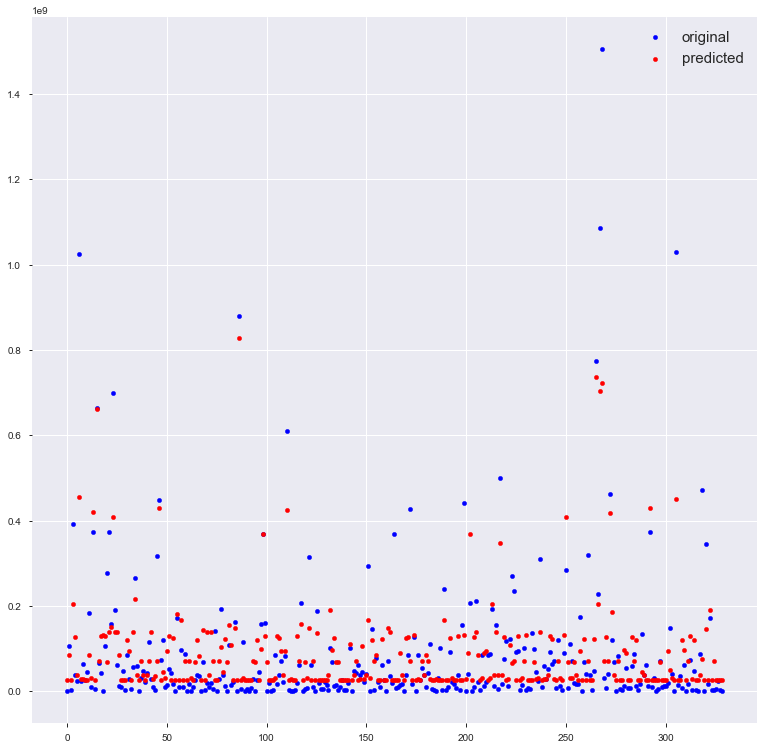

In [93]:
x_ax = range(len(ytest))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, ytest, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.show()

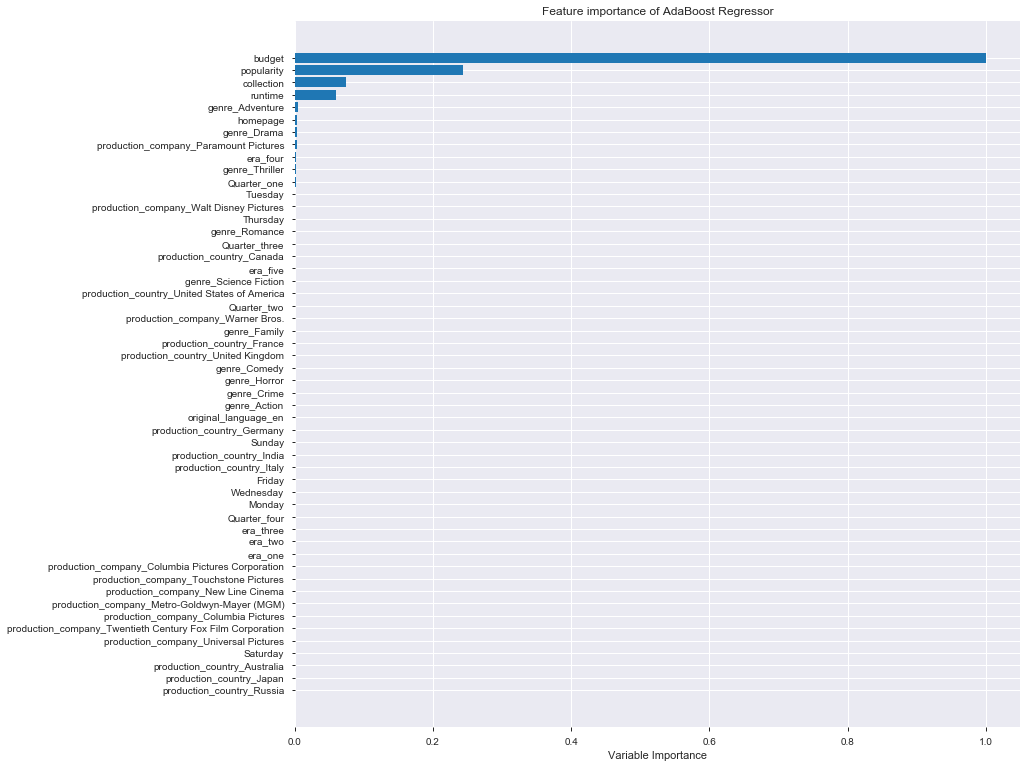

In [94]:
#피처 중요도 도표 그리기
featureImportance = ada_reg.feature_importances_
 
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, x.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.rcParams["figure.figsize"] = (13,27)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.title('Feature importance of AdaBoost Regressor')
plt.show()

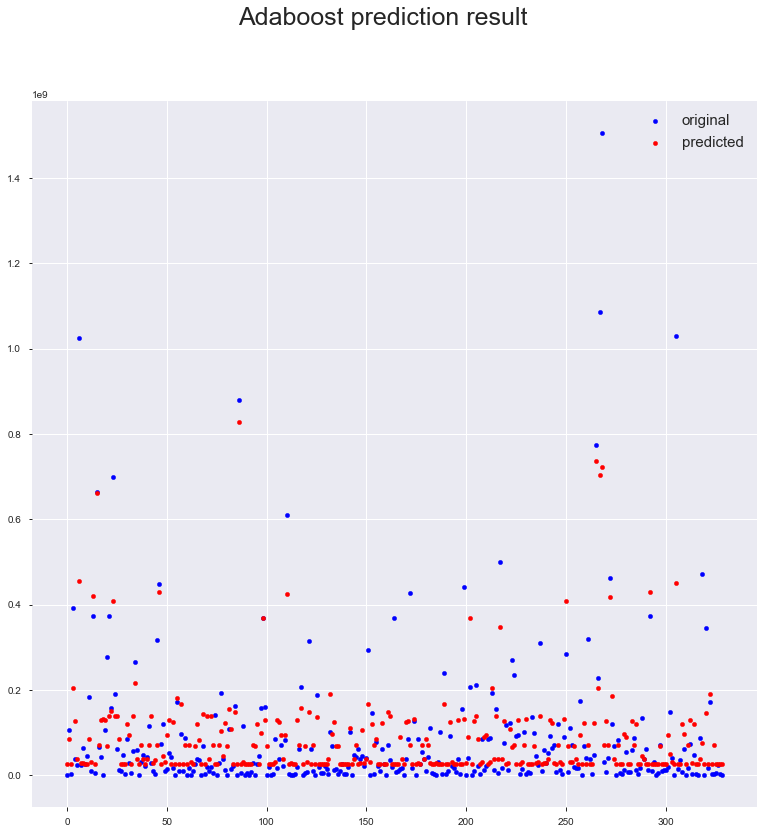

In [95]:
x_ax = range(len(ytest))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, ytest, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.suptitle('Adaboost prediction result', fontsize=25)
plt.show()

In [ ]:
# 단점 : 모델 running 속도가 오래걸림, 오버피팅의 위험성이 큼

# 4. Light GBM 

In [127]:
!pip install lightgbm
from lightgbm.sklearn import LGBMRegressor

In [128]:
lgbm_reg = LGBMRegressor(random_state = 0)
param_grid = {'learning_rate' : [0.01,0.05, 0.1, 0.5, 1], 'n_estimators' : [25, 50, 100, 200]}

grid_search = GridSearchCV(lgbm_reg, param_grid, cv=10,
                           return_train_score=True)

grid_search.fit(x, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=0,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'n_estimators': [25, 50, 100, 200]},
             pre_dispatch='2*n_jobs', ref

In [129]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 50}


In [130]:
best_estim=grid_search.best_estimator_
print(best_estim)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [131]:
# 따라서 최적의 모형은
lgbm_reg = best_estim

In [132]:
lgbm_reg.fit(xtrain, ytrain)

# K-fold - decision tree
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True)

kf_cv_scores = cross_val_score(lgbm_reg, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())



# prediction
ypred = lgbm_reg.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

K-fold CV average score: 0.64
MSE: 4542941035956787.00
RMSE: 67401342.98


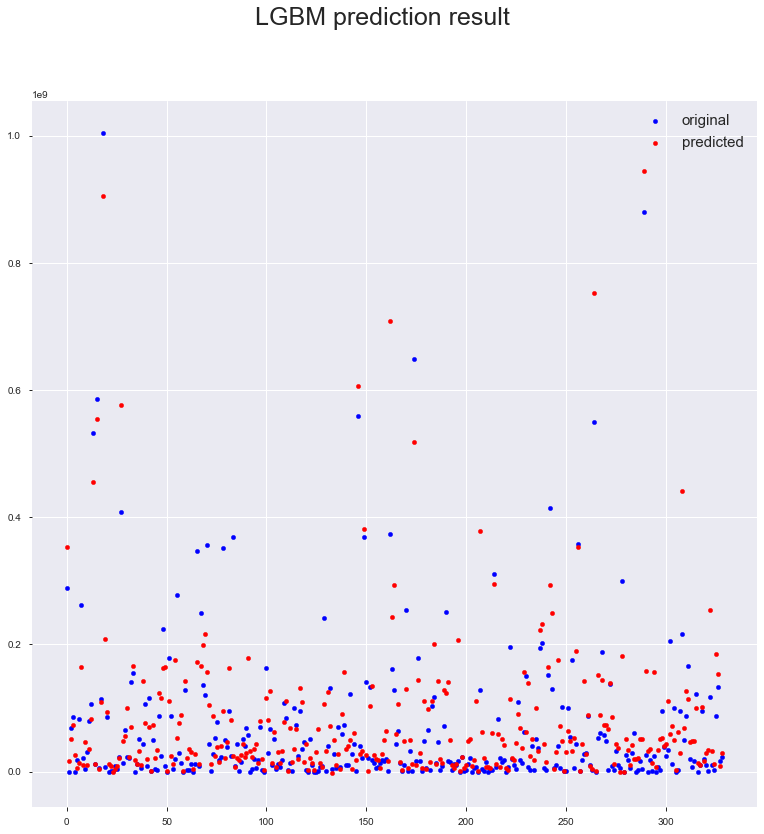

In [133]:
x_ax = range(len(ytest))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, ytest, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.suptitle('LGBM prediction result', fontsize=25)
plt.savefig('LGBM prediction result', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

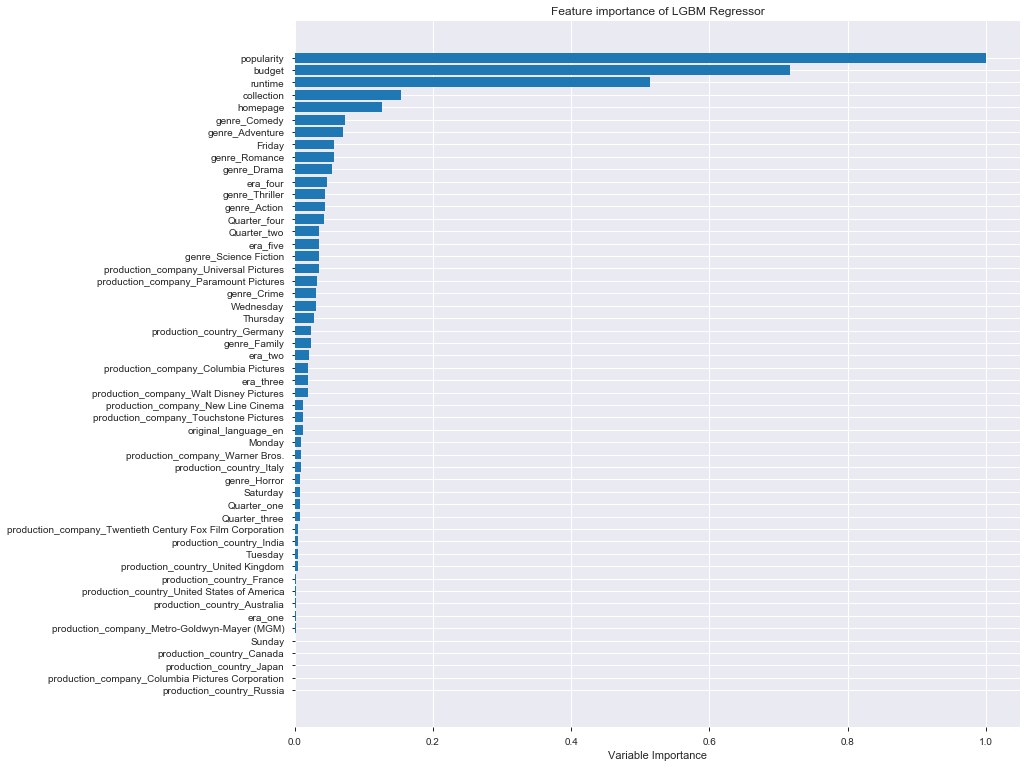

In [134]:
#피처 중요도 도표 그리기
featureImportance = lgbm_reg.feature_importances_
 
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, x.columns[sorted_idx])
plot.xlabel('Variable Importance')
plt.rcParams["figure.figsize"] = (13,27)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.title('Feature importance of LGBM Regressor')
plt.savefig('Feature importance of LGBM Regressor', bbox_inches ='tight', dpi = 300,facecolor='#eeeeee')

# 5. XGboost 

In [79]:
!pip install xgboost
from xgboost import XGBRegressor
import xgboost as xgb

In [80]:
xgb_reg = xgb.XGBRegressor(random_state = 0)
param_grid = {'learning_rate' : [0.01,0.05, 0.1, 0.5,1], 'n_estimators' : [25, 50, 100,200]}

grid_search = GridSearchCV(xgb_reg, param_grid, cv=10,
                           return_train_score=True)

grid_search.fit(x, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constrai...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_para

In [81]:
print(grid_search.best_params_)

{'learning_rate': 0.05, 'n_estimators': 100}


In [82]:
best_estim=grid_search.best_estimator_
print(best_estim)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [83]:
# 따라서 최적의 모형은
xgb_reg = best_estim


In [84]:
xgb_reg.fit(xtrain, ytrain)

# K-fold - decision tree
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True)

kf_cv_scores = cross_val_score(xgb_reg, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())



# prediction
ypred = xgb_reg.predict(xtest)
mse = mean_squared_error(ytest,ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

K-fold CV average score: 0.61
MSE: 9167980132537480.00
RMSE: 95749569.88


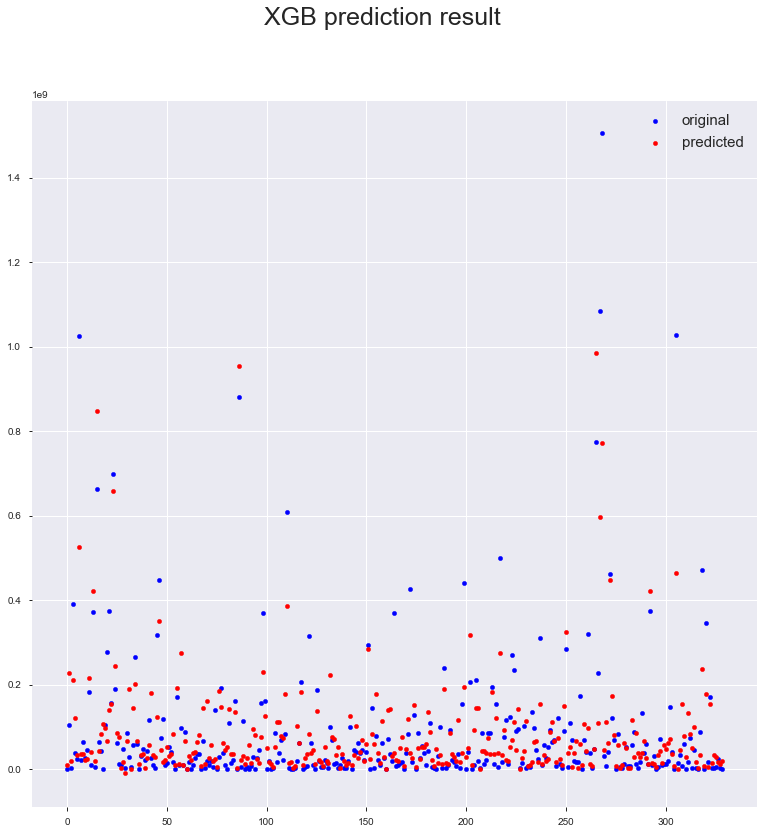

In [85]:
x_ax = range(len(ytest))
plt.rcParams["figure.figsize"] = (13,13)
plt.scatter(x_ax, ytest, s=20, color="blue", label="original")
plt.scatter(x_ax, ypred, s=20, color="red", label="predicted")
plt.legend(prop={'size': 15})
plt.suptitle('XGB prediction result', fontsize=25)
plt.show()

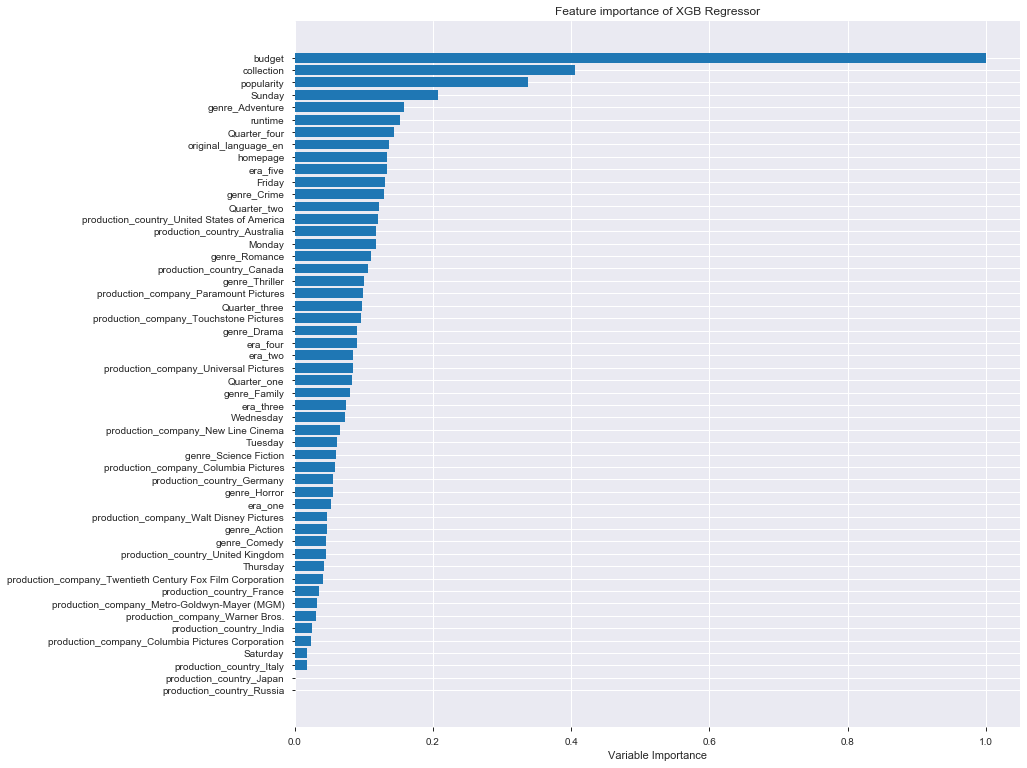

In [86]:
#피처 중요도 도표 그리기
featureImportance = xgb_reg.feature_importances_
 
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plot.barh(barPos, featureImportance[sorted_idx], align='center')
plot.yticks(barPos, x.columns[sorted_idx])
plot.xlabel('Variable Importance')
plt.rcParams["figure.figsize"] = (13,27)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.title('Feature importance of XGB Regressor')
plot.show()